In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
try:
    df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
except FileNotFoundError:
    print("Dataset file not found. Please ensure 'WA_Fn-UseC_-HR-Employee-Attrition.csv' is in your working directory.")
    print("You can download it from: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset")
    exit()

In [3]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import joblib

# 1. Load data
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df['MonthlyIncome'] = df['MonthlyIncome'] * 83

# 2. Encode categorical variables
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save encoder for later use

# 3. Select features and target

features = [
    'MonthlyIncome',
    'Age',
    'TotalWorkingYears',
    'DistanceFromHome',
    'PercentSalaryHike',
    'OverTime',
    'YearsAtCompany',
    'NumCompaniesWorked',
    'PerformanceRating'
]
X = df_encoded[features]
y = df_encoded['Attrition']

# 4. Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 5. Cross-validation scores (accuracy and F1)
cv_scores_acc = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
cv_scores_f1 = cross_val_score(rf, X, y, cv=cv, scoring='f1')

print(f"Cross-validated accuracy: {cv_scores_acc.mean():.4f} ± {cv_scores_acc.std():.4f}")
print(f"Cross-validated F1:       {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")

# 6. Fit the final model on all data
rf.fit(X, y)

# 7. Save the model and encoders
joblib.dump(rf, "rf_attrition_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

print("Model and encoders saved successfully!")


Cross-validated accuracy: 0.8422 ± 0.0123
Cross-validated F1:       0.2924 ± 0.0312
Model and encoders saved successfully!


In [16]:
import pandas as pd
import joblib

# 1. Load the trained model and label encoders
rf = joblib.load("rf_attrition_model.pkl")
label_encoders = joblib.load("label_encoders.pkl")

# 2. Prepare new employee data (replace with your own data!)
# Each column must match the 9-feature order used for training!
new_data = pd.DataFrame([{
    'MonthlyIncome': 1000,
    'Age': 26,
    'TotalWorkingYears': 2,
    'DistanceFromHome': 1,
    'PercentSalaryHike': 0,
    'OverTime': 'Yes',
    'YearsAtCompany': 2,
    'NumCompaniesWorked': 1,
    'PerformanceRating': 5
}])
# 3. Encode categorical variables
for col, le in label_encoders.items():
    if col in new_data.columns:
        new_data[col] = le.transform(new_data[col])

# 4. Predict Attrition
prediction = rf.predict(new_data)[0]
attrition_label = label_encoders['Attrition'].inverse_transform([prediction])[0]
attrition_prob = rf.predict_proba(new_data)[0][1]
if attrition_label == "Yes":
    print("HR Recommendation: This employee is AT RISK of leaving. Consider retention actions (e.g., interview, support, incentives).")
else:
    print("HR Recommendation: This employee is likely to stay. Maintain engagement and monitor normally.")
# Probability of "Yes" class

print(f"Predicted Attrition: {attrition_label}")
print(f"Probability of Leaving: {attrition_prob:.2%}")


HR Recommendation: This employee is likely to stay. Maintain engagement and monitor normally.
Predicted Attrition: No
Probability of Leaving: 45.00%


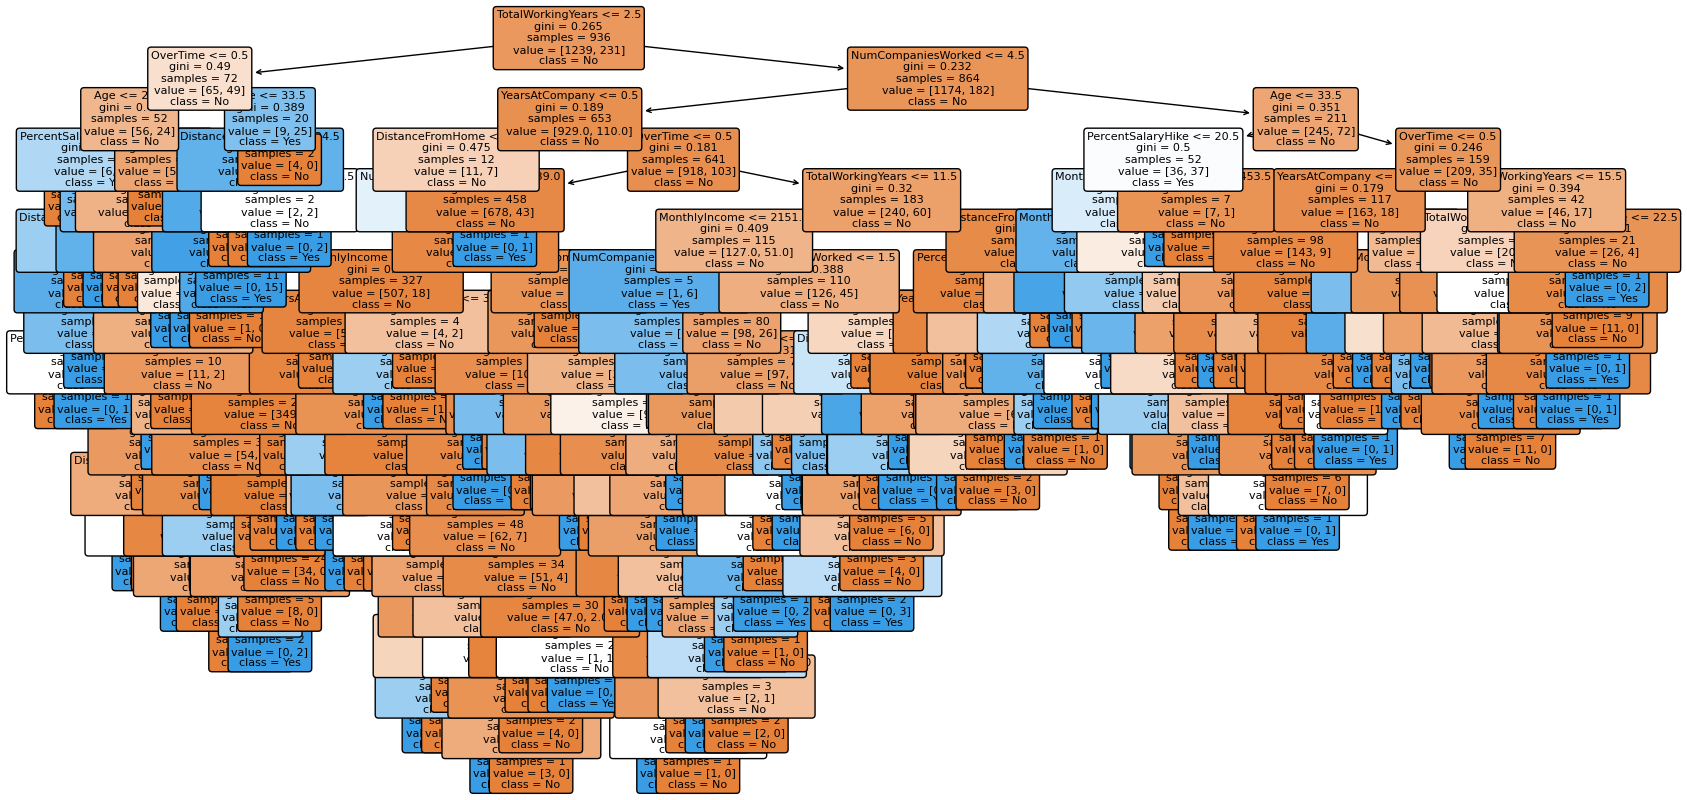

In [18]:
from sklearn import tree
import matplotlib.pyplot as plt

# Pick the first tree in the forest
estimator = rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
tree.plot_tree(estimator,
               feature_names=features,
               class_names=label_encoders['Attrition'].classes_,
               filled=True, rounded=True, fontsize=8)
plt.show()
